**Pandas** is an open-source python library constructed data analysis and manipulation. It is fast, powerful, flexible and easy. 

**SQL** (Structured Query Language) is a standardized programming language that is used to manage relational databases and perform various operations on the data in them.

**Apache Spark** is an open-source, multi-language engine used for big data. It utilizes in-memory caching, and optimized query execution for fast analytic queries against data of any size.


This notebook has been written in order to translate the query documentation from the one powerful tool to the other.

The libraries that I am going to use are:
- SQLite3
- Pandas
- PySpark

and IPython.display in order to see the image at the Notebook.

The database has been taken by https://www.sqlitetutorial.net/sqlite-sample-database/

Import of the libraries

In [1]:
import sqlite3
import pandas as pd

In [2]:
import findspark
findspark.init()
findspark.find()

'/Users/antonis1991/opt/anaconda3/lib/python3.8/site-packages/pyspark'

Before I continue, the website that I took the database has a helpful picture of the tables! Let's give a look to this picture:

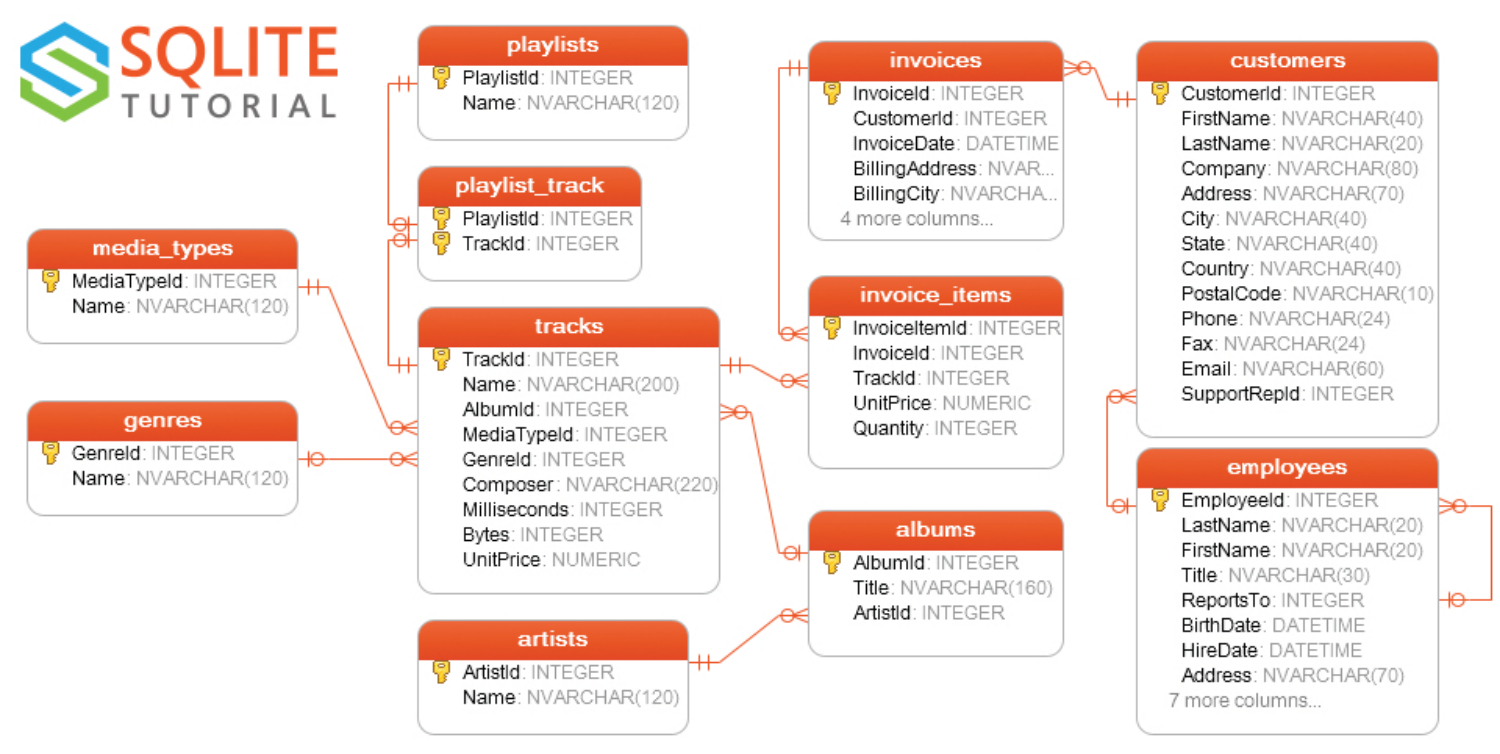

In [3]:
from IPython.display import Image
Image(filename='sqlite-sample-database-diagram-color.png')

From the diagram one can understand the connections between parent and child table, one-to-many/many-to-many/many-to-one options, the types of the columns and the keys.

Before I start with the commands, I would like to explore the database, like I have no idea about the diagram.

I will start with sqlite3 to see which tables are included:

In [4]:
conn = sqlite3.connect("chinook.db")
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
for table_name in tables:
    table_name = table_name[0]
    
    print(table_name)

albums
sqlite_sequence
artists
customers
employees
genres
invoices
invoice_items
media_types
playlists
playlist_track
tracks
sqlite_stat1


I store them into a pandas dataframe:

In [5]:
tables_database = pd.DataFrame(tables,columns=["Table Name"])
tables_database

,Table Name
0,albums
1,sqlite_sequence
2,artists
3,customers
4,employees
5,genres
6,invoices
7,invoice_items
8,media_types
9,playlists


Let's find out the tables information and foreign keys on the tables

In [6]:
rows = cursor.execute("SELECT name FROM sqlite_master WHERE type = 'table'")
tables = [row[0] for row in rows]

def sql_identifier(s):
    return '"' + s.replace('"', '""') + '"'

tables_infos, foreign_key_info = [], []
for table in tables:
    tables_infos.append(cursor.execute("PRAGMA table_info({})".format(sql_identifier(table))).fetchall())
    foreign_key_info.append(cursor.execute("PRAGMA foreign_key_list({})".format(sql_identifier(table))).fetchall())

The tables_info has the columns of each tables. If the last inserted value of a column is equal to 1, this means that this is the primary key of the table. Let's find out the primary key of the tables:

In [7]:
primary_key = {}
for info,name in zip(tables_infos,tables):
    i = 0
    while i<len(info):
        if info[i][-1]==1:
            key = info[i][1]
            break
        else:
            i +=1
    primary_key[name] = key
    key = None
    
primary_key

{'albums': 'AlbumId',
 'sqlite_sequence': None,
 'artists': 'ArtistId',
 'customers': 'CustomerId',
 'employees': 'EmployeeId',
 'genres': 'GenreId',
 'invoices': 'InvoiceId',
 'invoice_items': 'InvoiceLineId',
 'media_types': 'MediaTypeId',
 'playlists': 'PlaylistId',
 'playlist_track': 'PlaylistId',
 'tracks': 'TrackId',
 'sqlite_stat1': None}

I can insert a column in the pandas dataframe with the primary keys:

In [8]:
tables_database["Primary key"] = primary_key.values()
tables_database

,Table Name,Primary key
0,albums,AlbumId
1,sqlite_sequence,None
2,artists,ArtistId
3,customers,CustomerId
4,employees,EmployeeId
5,genres,GenreId
6,invoices,InvoiceId
7,invoice_items,InvoiceLineId
8,media_types,MediaTypeId
9,playlists,PlaylistId


Let's explore the foreign key:

In [9]:
foreign_key = []
for i in range(len(foreign_key_info)):
    if len(foreign_key_info[i])!=0:
        length = len(foreign_key_info[i])
        key = []
        for j in range(length):
                print(tables[i], ":",foreign_key_info[i][j][2],foreign_key_info[i][j][3],foreign_key_info[i][j][4])
                key.append([foreign_key_info[i][j][2],foreign_key_info[i][j][3],foreign_key_info[i][j][4]])
        foreign_key.append(key)
    else:
        foreign_key.append(None)
    print()

albums : artists ArtistId ArtistId



customers : employees SupportRepId EmployeeId

employees : employees ReportsTo EmployeeId


invoices : customers CustomerId CustomerId

invoice_items : tracks TrackId TrackId
invoice_items : invoices InvoiceId InvoiceId



playlist_track : tracks TrackId TrackId
playlist_track : playlists PlaylistId PlaylistId

tracks : media_types MediaTypeId MediaTypeId
tracks : genres GenreId GenreId
tracks : albums AlbumId AlbumId




Now I know the foreign key/keys of the tables. I can also store them into the initial dataframe:

In [10]:
foreign_key1, foreign_key2, foreign_key3 = [], [], []
for key in foreign_key:
    if key!=None:
        length = len(key)
        print(key[0])
        if len(key)==1:
             foreign_key1.append(key[0])
             foreign_key2.append(None)
             foreign_key3.append(None)
        elif len(key)==2:
            foreign_key1.append(key[0])
            foreign_key2.append(key[1])
            foreign_key3.append(None)
        else:
            foreign_key1.append(key[0])
            foreign_key2.append(key[1])
            foreign_key3.append(key[2])
    else:
        foreign_key1.append(None)
        foreign_key2.append(None)
        foreign_key3.append(None)
        
        

tables_database["Foreign key 1(connected table, column, column connected table)"] = foreign_key1
tables_database["Foreign key 2(connected table, column, column connected table)"] = foreign_key2
tables_database["Foreign key 3(connected table, column, column connected table)"] = foreign_key3

tables_database

['artists', 'ArtistId', 'ArtistId']
['employees', 'SupportRepId', 'EmployeeId']
['employees', 'ReportsTo', 'EmployeeId']
['customers', 'CustomerId', 'CustomerId']
['tracks', 'TrackId', 'TrackId']
['tracks', 'TrackId', 'TrackId']
['media_types', 'MediaTypeId', 'MediaTypeId']


,Table Name,Primary key,"Foreign key 1(connected table, column, column connected table)","Foreign key 2(connected table, column, column connected table)","Foreign key 3(connected table, column, column connected table)"
0,albums,AlbumId,"[artists, ArtistId, ArtistId]",None,None
1,sqlite_sequence,None,None,None,None
2,artists,ArtistId,None,None,None
3,customers,CustomerId,"[employees, SupportRepId, EmployeeId]",None,None
4,employees,EmployeeId,"[employees, ReportsTo, EmployeeId]",None,None
5,genres,GenreId,None,None,None
6,invoices,InvoiceId,"[customers, CustomerId, CustomerId]",None,None
7,invoice_items,InvoiceLineId,"[tracks, TrackId, TrackId]","[invoices, InvoiceId, InvoiceId]",None
8,media_types,MediaTypeId,None,None,None
9,playlists,PlaylistId,None,None,None


I have understood what is happening in terms of the primary and secondary(foreign) keys for the tables. Let's start checking out queries with pandas, sqlite and pyspark.

# Let's start with some commands

## Let's see the customers table

- #### sql command within Pandas query

In [11]:
customers_pdf = pd.read_sql_query("SELECT * FROM %s;" %tables_database["Table Name"][3],conn)
customers_pdf.head(5)

,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId
0,1,Luís,Gonçalves,Embraer - Empresa Brasileira de Aeronáutica S.A.,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,+55 (12) 3923-5555,+55 (12) 3923-5566,luisg@embraer.com.br,3
1,2,Leonie,Köhler,None,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,+49 0711 2842222,None,leonekohler@surfeu.de,5
2,3,François,Tremblay,None,1498 rue Bélanger,Montréal,QC,Canada,H2G 1A7,+1 (514) 721-4711,None,ftremblay@gmail.com,3
3,4,Bjørn,Hansen,None,Ullevålsveien 14,Oslo,None,Norway,0171,+47 22 44 22 22,None,bjorn.hansen@yahoo.no,4
4,5,František,Wichterlová,JetBrains s.r.o.,Klanova 9/506,Prague,None,Czech Republic,14700,+420 2 4172 5555,+420 2 4172 5555,frantisekw@jetbrains.com,4


- #### Pyspark

In [12]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.config('spark.jars.packages', 'org.xerial:sqlite-jdbc:3.34.0').getOrCreate()

customers_pyspark = spark.read.format('jdbc').options(driver='org.sqlite.JDBC', dbtable=tables_database["Table Name"][3],
                                                      url='jdbc:sqlite:chinook.db').load()

customers_pyspark.show(5)

+----------+---------+-----------+--------------------+--------------------+-------------------+-----+--------------+----------+------------------+------------------+--------------------+------------+
|CustomerId|FirstName|   LastName|             Company|             Address|               City|State|       Country|PostalCode|             Phone|               Fax|               Email|SupportRepId|
+----------+---------+-----------+--------------------+--------------------+-------------------+-----+--------------+----------+------------------+------------------+--------------------+------------+
|         1|     Luís|  Gonçalves|Embraer - Empresa...|Av. Brigadeiro Fa...|São José dos Campos|   SP|        Brazil| 12227-000|+55 (12) 3923-5555|+55 (12) 3923-5566|luisg@embraer.com.br|           3|
|         2|   Leonie|     Köhler|                null|Theodor-Heuss-Str...|          Stuttgart| null|       Germany|     70174|  +49 0711 2842222|              null|leonekohler@surfe...|         

## Let's see the rows where country is Brazil

- #### Pandas

In [13]:
customers_pdf[customers_pdf.Country=="Brazil"]

,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId
0,1,Luís,Gonçalves,Embraer - Empresa Brasileira de Aeronáutica S.A.,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,+55 (12) 3923-5555,+55 (12) 3923-5566,luisg@embraer.com.br,3
9,10,Eduardo,Martins,Woodstock Discos,"Rua Dr. Falcão Filho, 155",São Paulo,SP,Brazil,01007-010,+55 (11) 3033-5446,+55 (11) 3033-4564,eduardo@woodstock.com.br,4
10,11,Alexandre,Rocha,Banco do Brasil S.A.,"Av. Paulista, 2022",São Paulo,SP,Brazil,01310-200,+55 (11) 3055-3278,+55 (11) 3055-8131,alero@uol.com.br,5
11,12,Roberto,Almeida,Riotur,"Praça Pio X, 119",Rio de Janeiro,RJ,Brazil,20040-020,+55 (21) 2271-7000,+55 (21) 2271-7070,roberto.almeida@riotur.gov.br,3
12,13,Fernanda,Ramos,None,Qe 7 Bloco G,Brasília,DF,Brazil,71020-677,+55 (61) 3363-5547,+55 (61) 3363-7855,fernadaramos4@uol.com.br,4


- #### SQL query in Pandas dataframe

In [14]:
sql_command = "SELECT * FROM customers WHERE Country='Brazil';"
pd.read_sql_query(sql_command,conn)

,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId
0,1,Luís,Gonçalves,Embraer - Empresa Brasileira de Aeronáutica S.A.,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,+55 (12) 3923-5555,+55 (12) 3923-5566,luisg@embraer.com.br,3
1,10,Eduardo,Martins,Woodstock Discos,"Rua Dr. Falcão Filho, 155",São Paulo,SP,Brazil,01007-010,+55 (11) 3033-5446,+55 (11) 3033-4564,eduardo@woodstock.com.br,4
2,11,Alexandre,Rocha,Banco do Brasil S.A.,"Av. Paulista, 2022",São Paulo,SP,Brazil,01310-200,+55 (11) 3055-3278,+55 (11) 3055-8131,alero@uol.com.br,5
3,12,Roberto,Almeida,Riotur,"Praça Pio X, 119",Rio de Janeiro,RJ,Brazil,20040-020,+55 (21) 2271-7000,+55 (21) 2271-7070,roberto.almeida@riotur.gov.br,3
4,13,Fernanda,Ramos,None,Qe 7 Bloco G,Brasília,DF,Brazil,71020-677,+55 (61) 3363-5547,+55 (61) 3363-7855,fernadaramos4@uol.com.br,4


- #### Pyspark

In [15]:
customers_pyspark.where("Country='Brazil'").show()

+----------+---------+---------+--------------------+--------------------+-------------------+-----+-------+----------+------------------+------------------+--------------------+------------+
|CustomerId|FirstName| LastName|             Company|             Address|               City|State|Country|PostalCode|             Phone|               Fax|               Email|SupportRepId|
+----------+---------+---------+--------------------+--------------------+-------------------+-----+-------+----------+------------------+------------------+--------------------+------------+
|         1|     Luís|Gonçalves|Embraer - Empresa...|Av. Brigadeiro Fa...|São José dos Campos|   SP| Brazil| 12227-000|+55 (12) 3923-5555|+55 (12) 3923-5566|luisg@embraer.com.br|           3|
|        10|  Eduardo|  Martins|    Woodstock Discos|Rua Dr. Falcão Fi...|          São Paulo|   SP| Brazil| 01007-010|+55 (11) 3033-5446|+55 (11) 3033-4564|eduardo@woodstock...|           4|
|        11|Alexandre|    Rocha|Banco do

- #### SQL query within Pyspark

Firstly, I need to change globally the template view. Specifically, I will give the name Customers in otder to use the sql commandas in pyspark

In [16]:
spark.read.format('jdbc')\
          .options(driver='org.sqlite.JDBC', dbtable=tables_database["Table Name"][3],url='jdbc:sqlite:chinook.db')\
          .load().createOrReplaceTempView("Customers")

In [17]:
spark.sql(sql_command).show()

+----------+---------+---------+--------------------+--------------------+-------------------+-----+-------+----------+------------------+------------------+--------------------+------------+
|CustomerId|FirstName| LastName|             Company|             Address|               City|State|Country|PostalCode|             Phone|               Fax|               Email|SupportRepId|
+----------+---------+---------+--------------------+--------------------+-------------------+-----+-------+----------+------------------+------------------+--------------------+------------+
|         1|     Luís|Gonçalves|Embraer - Empresa...|Av. Brigadeiro Fa...|São José dos Campos|   SP| Brazil| 12227-000|+55 (12) 3923-5555|+55 (12) 3923-5566|luisg@embraer.com.br|           3|
|        10|  Eduardo|  Martins|    Woodstock Discos|Rua Dr. Falcão Fi...|          São Paulo|   SP| Brazil| 01007-010|+55 (11) 3033-5446|+55 (11) 3033-4564|eduardo@woodstock...|           4|
|        11|Alexandre|    Rocha|Banco do

## Let's see how many costumers do I have from all of the different countries

- #### Pandas

In [18]:
customers_pdf.Country.value_counts(ascending=True)

Spain              1
Sweden             1
Italy              1
Denmark            1
Australia          1
Finland            1
Netherlands        1
Poland             1
Hungary            1
Argentina          1
Chile              1
Belgium            1
Norway             1
Ireland            1
Austria            1
India              2
Portugal           2
Czech Republic     2
United Kingdom     3
Germany            4
Brazil             5
France             5
Canada             8
USA               13
Name: Country, dtype: int64

This command in pandas returns a pandas.Series.

- #### sql query within Pandas

In [19]:
sql_command = "SELECT COUNTRY,COUNT(*) AS COUNT FROM Customers GROUP BY COUNTRY ORDER BY COUNT ASC;"
pd.read_sql_query(sql_command,conn)

,Country,COUNT
0,Argentina,1
1,Australia,1
2,Austria,1
3,Belgium,1
4,Chile,1
5,Denmark,1
6,Finland,1
7,Hungary,1
8,Ireland,1
9,Italy,1


- #### Pyspark

In [20]:
customers_per_country_pyspark = customers_pyspark.groupBy("Country").count().orderBy("Count", ascending=True)
customers_per_country_pyspark.show(customers_per_country_pyspark.count(),False)

+--------------+-----+
|Country       |count|
+--------------+-----+
|Belgium       |1    |
|Norway        |1    |
|Argentina     |1    |
|Italy         |1    |
|Austria       |1    |
|Hungary       |1    |
|Netherlands   |1    |
|Spain         |1    |
|Finland       |1    |
|Denmark       |1    |
|Sweden        |1    |
|Ireland       |1    |
|Chile         |1    |
|Poland        |1    |
|Australia     |1    |
|Czech Republic|2    |
|Portugal      |2    |
|India         |2    |
|United Kingdom|3    |
|Germany       |4    |
|France        |5    |
|Brazil        |5    |
|Canada        |8    |
|USA           |13   |
+--------------+-----+



- #### SQL query within Pyspark

In [21]:
spark.sql(sql_command).show(24)

+--------------+-----+
|       COUNTRY|COUNT|
+--------------+-----+
|       Belgium|    1|
|        Norway|    1|
|     Argentina|    1|
|         Italy|    1|
|       Austria|    1|
|       Hungary|    1|
|   Netherlands|    1|
|         Spain|    1|
|       Finland|    1|
|       Denmark|    1|
|        Sweden|    1|
|       Ireland|    1|
|         Chile|    1|
|        Poland|    1|
|     Australia|    1|
|Czech Republic|    2|
|      Portugal|    2|
|         India|    2|
|United Kingdom|    3|
|       Germany|    4|
|        France|    5|
|        Brazil|    5|
|        Canada|    8|
|           USA|   13|
+--------------+-----+



## Let's see how many customers for each country do we have, where they are more than 4.

- #### Pandas

In [22]:
customers_pdf.Country.value_counts()[customers_pdf.Country.value_counts().sort_values(ascending=False)>4]

USA       13
Canada     8
France     5
Brazil     5
Name: Country, dtype: int64

- #### SQL query within Pandas

Here, I need to create a subquery:

In [23]:
sql_command = """SELECT * FROM (SELECT COUNTRY,COUNT(*) AS Count 
                                        FROM Customers GROUP BY Country 
                                        HAVING COUNT>4) ORDER BY Count DESC"""
pd.read_sql_query(sql_command,conn)

,COUNTRY,Count
0,USA,13
1,Canada,8
2,Brazil,5
3,France,5


- #### Pyspark

In [24]:
customers_pyspark.groupBy("Country").count().alias("Count")\
                 .orderBy("Count",ascending=False).filter("Count>4").show()
# it also works by replacing filter with where

+-------+-----+
|Country|count|
+-------+-----+
|    USA|   13|
| Canada|    8|
| France|    5|
| Brazil|    5|
+-------+-----+



- #### SQL query within Pyspark

In [25]:
spark.sql(sql_command).show()

+-------+-----+
|COUNTRY|Count|
+-------+-----+
|    USA|   13|
| Canada|    8|
| France|    5|
| Brazil|    5|
+-------+-----+



## Let's sort the values by two columns, the City and and the Country and see the first 5

- #### Pandas

In [26]:
customers_pdf.sort_values(by=["Country","City"]).head(5)

,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId
55,56,Diego,Gutiérrez,None,307 Macacha Güemes,Buenos Aires,None,Argentina,1106,+54 (0)11 4311 4333,None,diego.gutierrez@yahoo.ar,4
54,55,Mark,Taylor,None,421 Bourke Street,Sidney,NSW,Australia,2010,+61 (02) 9332 3633,None,mark.taylor@yahoo.au,4
6,7,Astrid,Gruber,None,"Rotenturmstraße 4, 1010 Innere Stadt",Vienne,None,Austria,1010,+43 01 5134505,None,astrid.gruber@apple.at,5
7,8,Daan,Peeters,None,Grétrystraat 63,Brussels,None,Belgium,1000,+32 02 219 03 03,None,daan_peeters@apple.be,4
12,13,Fernanda,Ramos,None,Qe 7 Bloco G,Brasília,DF,Brazil,71020-677,+55 (61) 3363-5547,+55 (61) 3363-7855,fernadaramos4@uol.com.br,4


- #### SQL query within pandas

In [27]:
sql_command = """SELECT * FROM Customers ORDER BY Country,City LIMIT 5;"""
pd.read_sql_query(sql_command,conn)

,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId
0,56,Diego,Gutiérrez,None,307 Macacha Güemes,Buenos Aires,None,Argentina,1106,+54 (0)11 4311 4333,None,diego.gutierrez@yahoo.ar,4
1,55,Mark,Taylor,None,421 Bourke Street,Sidney,NSW,Australia,2010,+61 (02) 9332 3633,None,mark.taylor@yahoo.au,4
2,7,Astrid,Gruber,None,"Rotenturmstraße 4, 1010 Innere Stadt",Vienne,None,Austria,1010,+43 01 5134505,None,astrid.gruber@apple.at,5
3,8,Daan,Peeters,None,Grétrystraat 63,Brussels,None,Belgium,1000,+32 02 219 03 03,None,daan_peeters@apple.be,4
4,13,Fernanda,Ramos,None,Qe 7 Bloco G,Brasília,DF,Brazil,71020-677,+55 (61) 3363-5547,+55 (61) 3363-7855,fernadaramos4@uol.com.br,4


- #### Pyspark

In [28]:
customers_pyspark.orderBy("Country","City").show(5)

+----------+---------+---------+-------+--------------------+------------+-----+---------+----------+-------------------+------------------+--------------------+------------+
|CustomerId|FirstName| LastName|Company|             Address|        City|State|  Country|PostalCode|              Phone|               Fax|               Email|SupportRepId|
+----------+---------+---------+-------+--------------------+------------+-----+---------+----------+-------------------+------------------+--------------------+------------+
|        56|    Diego|Gutiérrez|   null|  307 Macacha Güemes|Buenos Aires| null|Argentina|      1106|+54 (0)11 4311 4333|              null|diego.gutierrez@y...|           4|
|        55|     Mark|   Taylor|   null|   421 Bourke Street|      Sidney|  NSW|Australia|      2010| +61 (02) 9332 3633|              null|mark.taylor@yahoo.au|           4|
|         7|   Astrid|   Gruber|   null|Rotenturmstraße 4...|      Vienne| null|  Austria|      1010|     +43 01 5134505|    

- #### SQL query within pyspark

In [29]:
spark.sql(sql_command).show(5)

+----------+---------+---------+-------+--------------------+------------+-----+---------+----------+-------------------+------------------+--------------------+------------+
|CustomerId|FirstName| LastName|Company|             Address|        City|State|  Country|PostalCode|              Phone|               Fax|               Email|SupportRepId|
+----------+---------+---------+-------+--------------------+------------+-----+---------+----------+-------------------+------------------+--------------------+------------+
|        56|    Diego|Gutiérrez|   null|  307 Macacha Güemes|Buenos Aires| null|Argentina|      1106|+54 (0)11 4311 4333|              null|diego.gutierrez@y...|           4|
|        55|     Mark|   Taylor|   null|   421 Bourke Street|      Sidney|  NSW|Australia|      2010| +61 (02) 9332 3633|              null|mark.taylor@yahoo.au|           4|
|         7|   Astrid|   Gruber|   null|Rotenturmstraße 4...|      Vienne| null|  Austria|      1010|     +43 01 5134505|    

## Let's see the city, postal code and name of the people that are coming from Germany, by descending the postal code.

- #### Pandas

In [30]:
customers_pdf[customers_pdf.Country=="Germany"].sort_values(by="PostalCode")[["FirstName","LastName","City","PostalCode"]]

,FirstName,LastName,City,PostalCode
37,Niklas,Schröder,Berlin,10779
35,Hannah,Schneider,Berlin,10789
36,Fynn,Zimmermann,Frankfurt,60316
1,Leonie,Köhler,Stuttgart,70174


- #### SQL query within Pandas

In [31]:
sql_command = """SELECT FirstName,LastName,City,PostalCode FROM CUSTOMERS WHERE Country='Germany' ORDER BY PostalCode;"""
pd.read_sql_query(sql_command,conn)

,FirstName,LastName,City,PostalCode
0,Niklas,Schröder,Berlin,10779
1,Hannah,Schneider,Berlin,10789
2,Fynn,Zimmermann,Frankfurt,60316
3,Leonie,Köhler,Stuttgart,70174


- #### Pyspark

In [32]:
customers_pyspark.select("FirstName","LastName","City","PostalCode")\
                 .where("Country='Germany'")\
                 .orderBy("PostalCode").show()

+---------+----------+---------+----------+
|FirstName|  LastName|     City|PostalCode|
+---------+----------+---------+----------+
|   Niklas|  Schröder|   Berlin|     10779|
|   Hannah| Schneider|   Berlin|     10789|
|     Fynn|Zimmermann|Frankfurt|     60316|
|   Leonie|    Köhler|Stuttgart|     70174|
+---------+----------+---------+----------+



- #### SQL query within Pyspark

In [33]:
spark.sql(sql_command).show()

+---------+----------+---------+----------+
|FirstName|  LastName|     City|PostalCode|
+---------+----------+---------+----------+
|   Niklas|  Schröder|   Berlin|     10779|
|   Hannah| Schneider|   Berlin|     10789|
|     Fynn|Zimmermann|Frankfurt|     60316|
|   Leonie|    Köhler|Stuttgart|     70174|
+---------+----------+---------+----------+



## Let's find the rows where values are null

- #### Pandas

In [34]:
customers_pdf[customers_pdf.isna().any(axis=1)]

,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId
1,2,Leonie,Köhler,None,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,+49 0711 2842222,None,leonekohler@surfeu.de,5
2,3,François,Tremblay,None,1498 rue Bélanger,Montréal,QC,Canada,H2G 1A7,+1 (514) 721-4711,None,ftremblay@gmail.com,3
3,4,Bjørn,Hansen,None,Ullevålsveien 14,Oslo,None,Norway,0171,+47 22 44 22 22,None,bjorn.hansen@yahoo.no,4
4,5,František,Wichterlová,JetBrains s.r.o.,Klanova 9/506,Prague,None,Czech Republic,14700,+420 2 4172 5555,+420 2 4172 5555,frantisekw@jetbrains.com,4
5,6,Helena,Holý,None,Rilská 3174/6,Prague,None,Czech Republic,14300,+420 2 4177 0449,None,hholy@gmail.com,5
6,7,Astrid,Gruber,None,"Rotenturmstraße 4, 1010 Innere Stadt",Vienne,None,Austria,1010,+43 01 5134505,None,astrid.gruber@apple.at,5
7,8,Daan,Peeters,None,Grétrystraat 63,Brussels,None,Belgium,1000,+32 02 219 03 03,None,daan_peeters@apple.be,4
8,9,Kara,Nielsen,None,Sønder Boulevard 51,Copenhagen,None,Denmark,1720,+453 3331 9991,None,kara.nielsen@jubii.dk,4
12,13,Fernanda,Ramos,None,Qe 7 Bloco G,Brasília,DF,Brazil,71020-677,+55 (61) 3363-5547,+55 (61) 3363-7855,fernadaramos4@uol.com.br,4
17,18,Michelle,Brooks,None,627 Broadway,New York,NY,USA,10012-2612,+1 (212) 221-3546,+1 (212) 221-4679,michelleb@aol.com,3


- #### SQL query within pandas

In [35]:
sql_command = """SELECT * FROM CUSTOMERS 
                    WHERE FirstName + LastName + Company + Address + 
                                    City + State + Country + PostalCode + 
                                    Phone + Fax + Email + SupportRepId IS NULL;"""
pd.read_sql_query(sql_command,conn)

,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId
0,2,Leonie,Köhler,None,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,+49 0711 2842222,None,leonekohler@surfeu.de,5
1,3,François,Tremblay,None,1498 rue Bélanger,Montréal,QC,Canada,H2G 1A7,+1 (514) 721-4711,None,ftremblay@gmail.com,3
2,4,Bjørn,Hansen,None,Ullevålsveien 14,Oslo,None,Norway,0171,+47 22 44 22 22,None,bjorn.hansen@yahoo.no,4
3,5,František,Wichterlová,JetBrains s.r.o.,Klanova 9/506,Prague,None,Czech Republic,14700,+420 2 4172 5555,+420 2 4172 5555,frantisekw@jetbrains.com,4
4,6,Helena,Holý,None,Rilská 3174/6,Prague,None,Czech Republic,14300,+420 2 4177 0449,None,hholy@gmail.com,5
5,7,Astrid,Gruber,None,"Rotenturmstraße 4, 1010 Innere Stadt",Vienne,None,Austria,1010,+43 01 5134505,None,astrid.gruber@apple.at,5
6,8,Daan,Peeters,None,Grétrystraat 63,Brussels,None,Belgium,1000,+32 02 219 03 03,None,daan_peeters@apple.be,4
7,9,Kara,Nielsen,None,Sønder Boulevard 51,Copenhagen,None,Denmark,1720,+453 3331 9991,None,kara.nielsen@jubii.dk,4
8,13,Fernanda,Ramos,None,Qe 7 Bloco G,Brasília,DF,Brazil,71020-677,+55 (61) 3363-5547,+55 (61) 3363-7855,fernadaramos4@uol.com.br,4
9,18,Michelle,Brooks,None,627 Broadway,New York,NY,USA,10012-2612,+1 (212) 221-3546,+1 (212) 221-4679,michelleb@aol.com,3


- #### Pyspark

In [36]:
from pyspark.sql import functions as F

filter_expr = F.exists(F.array(*customers_pyspark.columns), lambda x: x.isNull())
customers_pyspark.filter(filter_expr).show()

+----------+---------+-----------+----------------+--------------------+--------------+-----+--------------+----------+------------------+------------------+--------------------+------------+
|CustomerId|FirstName|   LastName|         Company|             Address|          City|State|       Country|PostalCode|             Phone|               Fax|               Email|SupportRepId|
+----------+---------+-----------+----------------+--------------------+--------------+-----+--------------+----------+------------------+------------------+--------------------+------------+
|         2|   Leonie|     Köhler|            null|Theodor-Heuss-Str...|     Stuttgart| null|       Germany|     70174|  +49 0711 2842222|              null|leonekohler@surfe...|           5|
|         3| François|   Tremblay|            null|   1498 rue Bélanger|      Montréal|   QC|        Canada|   H2G 1A7| +1 (514) 721-4711|              null| ftremblay@gmail.com|           3|
|         4|    Bjørn|     Hansen|      

- #### SQL query within Pyspark

In [37]:
spark.sql(sql_command).show()

+----------+---------+-----------+--------------------+--------------------+-------------------+-----+--------------+----------+------------------+------------------+--------------------+------------+
|CustomerId|FirstName|   LastName|             Company|             Address|               City|State|       Country|PostalCode|             Phone|               Fax|               Email|SupportRepId|
+----------+---------+-----------+--------------------+--------------------+-------------------+-----+--------------+----------+------------------+------------------+--------------------+------------+
|         1|     Luís|  Gonçalves|Embraer - Empresa...|Av. Brigadeiro Fa...|São José dos Campos|   SP|        Brazil| 12227-000|+55 (12) 3923-5555|+55 (12) 3923-5566|luisg@embraer.com.br|           3|
|         2|   Leonie|     Köhler|                null|Theodor-Heuss-Str...|          Stuttgart| null|       Germany|     70174|  +49 0711 2842222|              null|leonekohler@surfe...|         

# Let's see the Case command. Whoever is from USA will be noted as domestic, otherwise foreign.

- #### Pandas

In [38]:
domestic = customers_pdf[["CustomerId","FirstName","LastName","Country"]]
domestic["Name"] = domestic["FirstName"] + ' ' + domestic["LastName"]
domestic = domestic.drop(["FirstName","LastName"],axis=1)
group = []
for x in domestic.Country.values:
    if x=="USA": group.append("Domestic")
    else: group.append("Foreign")
        
domestic["Customer group"] = group
domestic.head(20)

<ipython-input-38-e03dc1211117>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  domestic["Name"] = domestic["FirstName"] + ' ' + domestic["LastName"]


,CustomerId,Country,Name,Customer group
0,1,Brazil,Luís Gonçalves,Foreign
1,2,Germany,Leonie Köhler,Foreign
2,3,Canada,François Tremblay,Foreign
3,4,Norway,Bjørn Hansen,Foreign
4,5,Czech Republic,František Wichterlová,Foreign
5,6,Czech Republic,Helena Holý,Foreign
6,7,Austria,Astrid Gruber,Foreign
7,8,Belgium,Daan Peeters,Foreign
8,9,Denmark,Kara Nielsen,Foreign
9,10,Brazil,Eduardo Martins,Foreign


With the command sample(...) it randomly chooses the number of rows that I ask

- #### SQL query within pandas

In [39]:
sql_command = """SELECT CustomerId, FirstName || ' '|| LastName As Name,
                    CASE Country
                        WHEN 'USA' THEN
                            'Dosmetic'
                        ELSE
                            'Foreign'
                    END CustomerGroup FROM customers"""

pd.read_sql_query(sql_command,conn).head(20)

,CustomerId,Name,CustomerGroup
0,1,Luís Gonçalves,Foreign
1,2,Leonie Köhler,Foreign
2,3,François Tremblay,Foreign
3,4,Bjørn Hansen,Foreign
4,5,František Wichterlová,Foreign
5,6,Helena Holý,Foreign
6,7,Astrid Gruber,Foreign
7,8,Daan Peeters,Foreign
8,9,Kara Nielsen,Foreign
9,10,Eduardo Martins,Foreign


- #### PySpark

In [40]:
from pyspark.sql.functions import when, concat_ws


cp_tr = customers_pyspark.select("CustomerId", "FirstName", "LastName","Country")
cp_tr = cp_tr.withColumn("Customer Group", when(customers_pyspark.Country=="USA", "Domestic")
                                           .otherwise("Foreign"))
cp_tr = cp_tr.select("CustomerId",concat_ws('_',cp_tr.FirstName, cp_tr.LastName).alias("Name"), "Customer Group")

cp_tr.show()

+----------+--------------------+--------------+
|CustomerId|                Name|Customer Group|
+----------+--------------------+--------------+
|         1|      Luís_Gonçalves|       Foreign|
|         2|       Leonie_Köhler|       Foreign|
|         3|   François_Tremblay|       Foreign|
|         4|        Bjørn_Hansen|       Foreign|
|         5|František_Wichter...|       Foreign|
|         6|         Helena_Holý|       Foreign|
|         7|       Astrid_Gruber|       Foreign|
|         8|        Daan_Peeters|       Foreign|
|         9|        Kara_Nielsen|       Foreign|
|        10|     Eduardo_Martins|       Foreign|
|        11|     Alexandre_Rocha|       Foreign|
|        12|     Roberto_Almeida|       Foreign|
|        13|      Fernanda_Ramos|       Foreign|
|        14|        Mark_Philips|       Foreign|
|        15|   Jennifer_Peterson|       Foreign|
|        16|        Frank_Harris|      Domestic|
|        17|          Jack_Smith|      Domestic|
|        18|     Mic

- #### SQL query within PySpark

In [41]:
spark.sql(sql_command).show()

+----------+--------------------+-------------+
|CustomerId|                Name|CustomerGroup|
+----------+--------------------+-------------+
|         1|      Luís Gonçalves|      Foreign|
|         2|       Leonie Köhler|      Foreign|
|         3|   François Tremblay|      Foreign|
|         4|        Bjørn Hansen|      Foreign|
|         5|František Wichter...|      Foreign|
|         6|         Helena Holý|      Foreign|
|         7|       Astrid Gruber|      Foreign|
|         8|        Daan Peeters|      Foreign|
|         9|        Kara Nielsen|      Foreign|
|        10|     Eduardo Martins|      Foreign|
|        11|     Alexandre Rocha|      Foreign|
|        12|     Roberto Almeida|      Foreign|
|        13|      Fernanda Ramos|      Foreign|
|        14|        Mark Philips|      Foreign|
|        15|   Jennifer Peterson|      Foreign|
|        16|        Frank Harris|     Dosmetic|
|        17|          Jack Smith|     Dosmetic|
|        18|     Michelle Brooks|     Do

I could have shown examples with join commands but in sqlite3 full outer join and right join have not been implemented yet.

# Appendix

## Let's create a spark-warehouse with initially one database, which will inlcude two tables

I already have the customers tables in the customers_pyspark. I will do the same for the employees and invoices tables.

The command:
employees_pyspark = spark.read.format('jdbc').options(driver='org.sqlite.JDBC', dbtable=tables_database["Table Name"][4],url='jdbc:sqlite:chinook.db').load()

failed to do it. Thus, I created a dataframe firstly and then I put the pandas dataframe to spark dataframes. 

In [42]:
# read the quaries and put them in pandas dataframe
employees_pdf = pd.read_sql_query("""SELECT * FROM %s;""" %tables_database["Table Name"][4],conn)
invoices_pdf = pd.read_sql_query("""SELECT * FROM %s;""" %tables_database["Table Name"][6],conn)

# put the dataframes to pyspark tables
employees_pyspark = spark.createDataFrame(employees_pdf)
invoices_pyspark = spark.createDataFrame(invoices_pdf)

Let's see the invoices tables

In [43]:
invoices_pyspark.show(4)

+---------+----------+-------------------+--------------------+-----------+------------+--------------+-----------------+-----+
|InvoiceId|CustomerId|        InvoiceDate|      BillingAddress|BillingCity|BillingState|BillingCountry|BillingPostalCode|Total|
+---------+----------+-------------------+--------------------+-----------+------------+--------------+-----------------+-----+
|        1|         2|2009-01-01 00:00:00|Theodor-Heuss-Str...|  Stuttgart|        null|       Germany|            70174| 1.98|
|        2|         4|2009-01-02 00:00:00|    Ullevålsveien 14|       Oslo|        null|        Norway|             0171| 3.96|
|        3|         8|2009-01-03 00:00:00|     Grétrystraat 63|   Brussels|        null|       Belgium|             1000| 5.94|
|        4|        14|2009-01-06 00:00:00|      8210 111 ST NW|   Edmonton|          AB|        Canada|          T6G 2C7| 8.91|
+---------+----------+-------------------+--------------------+-----------+------------+--------------+-

Let's create the warehouse:

In [44]:
from os.path import abspath

warehouse_location = abspath('spark-warehouse')

spark2 = SparkSession \
    .builder \
    .appName("Python Spark SQL Hive integration example") \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .enableHiveSupport() \
    .getOrCreate()

Create the database customers_empl_inv

In [45]:
spark.sql("CREATE DATABASE IF NOT EXISTS customers_empl_inv")

DataFrame[]

In [46]:
spark.sql('show databases').show()

+------------------+
|         namespace|
+------------------+
|customers_empl_inv|
|           default|
+------------------+



Let's put the tables in the database

In [47]:
customers_pyspark.write.mode("overwrite").saveAsTable("customers_empl_inv.Customers")

In [48]:
employees_pyspark.write.mode("overwrite").saveAsTable("customers_empl_inv.Employees")
invoices_pyspark.write.mode("overwrite").saveAsTable("customers_empl_inv.Invoices")

Let's give an eye to the tables of the database:

In [49]:
spark.sql("show tables from customers_empl_inv").show()

+------------------+---------+-----------+
|         namespace|tableName|isTemporary|
+------------------+---------+-----------+
|customers_empl_inv|customers|      false|
|customers_empl_inv|employees|      false|
|customers_empl_inv| invoices|      false|
|                  |customers|       true|
+------------------+---------+-----------+



Let's create a new table by joining specific columns of the tables employees and customers. Actually, the point of this table is to see which customer has been served by which employee.

In [50]:
employees_pyspark.select("FirstName","LastName","City","Country","EmployeeID").show()#.columns

+---------+--------+----------+-------+----------+
|FirstName|LastName|      City|Country|EmployeeID|
+---------+--------+----------+-------+----------+
|   Andrew|   Adams|  Edmonton| Canada|         1|
|    Nancy| Edwards|   Calgary| Canada|         2|
|     Jane| Peacock|   Calgary| Canada|         3|
| Margaret|    Park|   Calgary| Canada|         4|
|    Steve| Johnson|   Calgary| Canada|         5|
|  Michael|Mitchell|   Calgary| Canada|         6|
|   Robert|    King|Lethbridge| Canada|         7|
|    Laura|Callahan|Lethbridge| Canada|         8|
+---------+--------+----------+-------+----------+



In [51]:
customers_pyspark.select("FirstName","LastName","City","Country","SupportRepID").show()

+---------+-----------+-------------------+--------------+------------+
|FirstName|   LastName|               City|       Country|SupportRepID|
+---------+-----------+-------------------+--------------+------------+
|     Luís|  Gonçalves|São José dos Campos|        Brazil|           3|
|   Leonie|     Köhler|          Stuttgart|       Germany|           5|
| François|   Tremblay|           Montréal|        Canada|           3|
|    Bjørn|     Hansen|               Oslo|        Norway|           4|
|František|Wichterlová|             Prague|Czech Republic|           4|
|   Helena|       Holý|             Prague|Czech Republic|           5|
|   Astrid|     Gruber|             Vienne|       Austria|           5|
|     Daan|    Peeters|           Brussels|       Belgium|           4|
|     Kara|    Nielsen|         Copenhagen|       Denmark|           4|
|  Eduardo|    Martins|          São Paulo|        Brazil|           4|
|Alexandre|      Rocha|          São Paulo|        Brazil|      

In [52]:
tables_database

,Table Name,Primary key,"Foreign key 1(connected table, column, column connected table)","Foreign key 2(connected table, column, column connected table)","Foreign key 3(connected table, column, column connected table)"
0,albums,AlbumId,"[artists, ArtistId, ArtistId]",None,None
1,sqlite_sequence,None,None,None,None
2,artists,ArtistId,None,None,None
3,customers,CustomerId,"[employees, SupportRepId, EmployeeId]",None,None
4,employees,EmployeeId,"[employees, ReportsTo, EmployeeId]",None,None
5,genres,GenreId,None,None,None
6,invoices,InvoiceId,"[customers, CustomerId, CustomerId]",None,None
7,invoice_items,InvoiceLineId,"[tracks, TrackId, TrackId]","[invoices, InvoiceId, InvoiceId]",None
8,media_types,MediaTypeId,None,None,None
9,playlists,PlaylistId,None,None,None


Here, we can see that the customers table have a foreign key on EmployeeId from employees table and this is refered to SupportRepId at customers table.

I must firstly rename some columns because both tables has same column name but they are refering to different peope (FirstName, LastName, City, Country)

- #### Pyspark

In [53]:
customers_renamed_pyspark = customers_pyspark.withColumnRenamed("FirstName","CustomersFN")\
                                             .withColumnRenamed("LastName","CustomersLN")\
                                             .withColumnRenamed("City","Customers_City")\
                                             .withColumnRenamed("Country","Customers_Country")


employees_renamed_pyspark = employees_pyspark.withColumnRenamed("FirstName","Empl_FN")\
                                             .withColumnRenamed("LastName","Empl_LN")\
                                             .withColumnRenamed("City","Empl_City")\
                                             .withColumnRenamed("Country","Empl_Country")

In [54]:
joined_table = customers_renamed_pyspark.select("CustomersFN","CustomersLN","Customers_City","Customers_Country","SupportRepID")\
                                        .join(employees_renamed_pyspark.select("EmployeeID","Empl_FN","Empl_LN","Empl_City","Empl_Country"), 
                                 customers_renamed_pyspark["SupportRepID"]==employees_renamed_pyspark["EmployeeID"], how='left')

joined_table = joined_table.drop("SupportRepID","EmployeeID")

In [55]:
joined_table.where("Empl_Country='Canada' and Customers_Country='Canada'").show()

+-----------+-----------+--------------+-----------------+--------+-------+---------+------------+
|CustomersFN|CustomersLN|Customers_City|Customers_Country| Empl_FN|Empl_LN|Empl_City|Empl_Country|
+-----------+-----------+--------------+-----------------+--------+-------+---------+------------+
|   François|   Tremblay|      Montréal|           Canada|    Jane|Peacock|  Calgary|      Canada|
|   Jennifer|   Peterson|     Vancouver|           Canada|    Jane|Peacock|  Calgary|      Canada|
|     Robert|      Brown|       Toronto|           Canada|    Jane|Peacock|  Calgary|      Canada|
|     Edward|    Francis|        Ottawa|           Canada|    Jane|Peacock|  Calgary|      Canada|
|      Ellie|   Sullivan|   Yellowknife|           Canada|    Jane|Peacock|  Calgary|      Canada|
|      Aaron|   Mitchell|      Winnipeg|           Canada|Margaret|   Park|  Calgary|      Canada|
|       Mark|    Philips|      Edmonton|           Canada|   Steve|Johnson|  Calgary|      Canada|
|     Mart

- #### Pandas

In [56]:
customers_renamed_pdf = customers_pdf.copy()
customers_renamed_pdf = customers_renamed_pdf[["FirstName","LastName","City","Country","SupportRepId"]]
customers_renamed_pdf.rename(columns={"FirstName":"CustomersFN", 
                                      "LastName":"CustomersLN",
                                      "City":"Customers_City",
                                      "Country":"Customers_Country"}, inplace=True)


employees_renamed_pdf = employees_pdf.copy()
employees_renamed_pdf.rename(columns={"FirstName":"Empl_FN", 
                                      "LastName":"Empl_LN",
                                      "City":"Empl_City",
                                      "Country":"Empl_Country"}, inplace=True)
employees_renamed_pdf = employees_renamed_pdf[["Empl_FN","Empl_LN","Empl_City","Empl_Country","EmployeeId"]]

In [57]:
joined_table_pdf = pd.merge(customers_renamed_pdf, employees_renamed_pdf,
                            left_on=customers_renamed_pdf["SupportRepId"],
                            right_on=employees_renamed_pdf["EmployeeId"],
                            how="left")

In [58]:
joined_table_pdf.drop(columns=["key_0","SupportRepId","EmployeeId"],inplace=True)

In [59]:
joined_table_pdf

,CustomersFN,CustomersLN,Customers_City,Customers_Country,Empl_FN,Empl_LN,Empl_City,Empl_Country
0,Luís,Gonçalves,São José dos Campos,Brazil,Jane,Peacock,Calgary,Canada
1,Leonie,Köhler,Stuttgart,Germany,Steve,Johnson,Calgary,Canada
2,François,Tremblay,Montréal,Canada,Jane,Peacock,Calgary,Canada
3,Bjørn,Hansen,Oslo,Norway,Margaret,Park,Calgary,Canada
4,František,Wichterlová,Prague,Czech Republic,Margaret,Park,Calgary,Canada
5,Helena,Holý,Prague,Czech Republic,Steve,Johnson,Calgary,Canada
6,Astrid,Gruber,Vienne,Austria,Steve,Johnson,Calgary,Canada
7,Daan,Peeters,Brussels,Belgium,Margaret,Park,Calgary,Canada
8,Kara,Nielsen,Copenhagen,Denmark,Margaret,Park,Calgary,Canada
9,Eduardo,Martins,São Paulo,Brazil,Margaret,Park,Calgary,Canada


In [60]:
joined_table_pdf[(joined_table_pdf.Empl_Country=="Canada") & (joined_table_pdf.Customers_Country=="Canada")]

,CustomersFN,CustomersLN,Customers_City,Customers_Country,Empl_FN,Empl_LN,Empl_City,Empl_Country
2,François,Tremblay,Montréal,Canada,Jane,Peacock,Calgary,Canada
13,Mark,Philips,Edmonton,Canada,Steve,Johnson,Calgary,Canada
14,Jennifer,Peterson,Vancouver,Canada,Jane,Peacock,Calgary,Canada
28,Robert,Brown,Toronto,Canada,Jane,Peacock,Calgary,Canada
29,Edward,Francis,Ottawa,Canada,Jane,Peacock,Calgary,Canada
30,Martha,Silk,Halifax,Canada,Steve,Johnson,Calgary,Canada
31,Aaron,Mitchell,Winnipeg,Canada,Margaret,Park,Calgary,Canada
32,Ellie,Sullivan,Yellowknife,Canada,Jane,Peacock,Calgary,Canada


### Now I will insert the joined table in the spark warehouse, in a new database

In [61]:
spark.sql("CREATE DATABASE IF NOT EXISTS joined_table")
joined_table.write.mode("overwrite").saveAsTable("joined_table.joined_customers_employees")

In [62]:
spark.sql("show databases").show()

+------------------+
|         namespace|
+------------------+
|customers_empl_inv|
|           default|
|      joined_table|
+------------------+



In [63]:
spark.sql("Show tables from joined_table;").show()

+------------+--------------------+-----------+
|   namespace|           tableName|isTemporary|
+------------+--------------------+-----------+
|joined_table|joined_customers_...|      false|
|            |           customers|       true|
+------------+--------------------+-----------+



In [64]:
conn.close()